In [1]:
import sys
import pathlib
import os
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from model_fit import read_features, parameter_fine_tuning, evaluate_model, weighted_ccc, separate_data, calc_metrics
import joblib

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'

# Pre-train the model

In [2]:
# model
model = joblib.load(f'{folder_path}/data/010_model_fine.tuned.joblib')
model.n_jobs=90

# covariates
covs = read_features(f'{folder_path}/data/008_cov_rscfi.txt')
print(f'{len(covs)} covariates')

# data
train = pd.read_parquet(f'{folder_path}/data/006_data_train.pq')
test = pd.read_parquet(f'{folder_path}/data/011_data_test.pred.pq')

# set up
cv = GroupKFold(n_splits=5) 
prop = 'ocd'
space = 'log1p'
tgt = f'{prop}_log1p'

train[tgt] = np.log1p(train[prop])
test[tgt] = np.log1p(test[prop])

model.fit(train[covs], train[tgt])

67 covariates


RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=120,
                      n_jobs=90)

# Calculate metrics for uncertainty at different PI

In [3]:
from trees_rf import cast_tree_rf
model = cast_tree_rf(model)
tree_predictions = model.predict(test[covs])

y_pred = np.mean(tree_predictions, axis=0)
y_pred = np.expm1(y_pred)

tree_predictions = np.expm1(tree_predictions)

# quantiles_95 = [0.025, 0.975]
# y_95 = np.percentile(tree_predictions, [q * 100 for q in quantiles_95], axis=0)
# piw = y_95[1,:] - y_95[0,:]


In [4]:
# calculate quantile predictions
quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]
y_q = np.percentile(tree_predictions, [q * 100 for q in quantiles], axis=0)

# calculate QCP
def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii,:], test[prop], quantiles[ii]))

In [5]:
# calculate PICP, PIW
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test[prop]))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

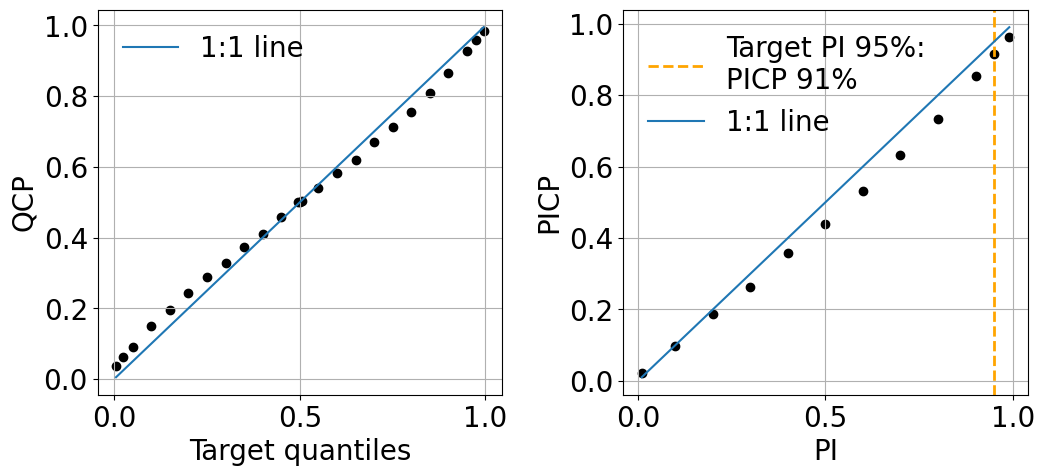

In [6]:
# general plot
import matplotlib.pyplot as plt

# Create a 1x2 grid for the plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot 1: Target quantiles vs. realized quantiles
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('Target quantiles', fontsize=20)
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].grid(True)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)

# Plot 2: PI vs. PICP
# ymin, ymax = axs[1].get_ylim()
# axs[1].plot([0.95, 0.95], [0,1], 
#             color='orange', linestyle='--', linewidth=2, label='Target PI 95%:\nPICP 93%')
axs[1].axvline(x=0.95, color='orange', linestyle='--', linewidth=2, label=f'Target PI 95%:\nPICP {picp[1]*100:.0f}%')  # Use axvline to draw a vertical line across the entire plot
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('PI', fontsize=20)
axs[1].set_ylabel('PICP', fontsize=20)
# axs[1].text(0.26, 0.16, f'PI 95% - PICP 93%', #\n{picp[1]:.2f}
#             ha='left', va='top', transform=axs[1].transAxes, fontsize=20)  # Adjusted text position
axs[1].grid(True)
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)

# Adjust layout to prevent overlapping and add space between the panels
plt.subplots_adjust(wspace=0.3)  # Increase the space between the two plots
plt.savefig(f'{folder_path}/figure/figure_evaluation_uncertainty.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the combined figure
plt.show()

In [7]:
# by strata
# calculate the metrics
lower_bound = np.percentile(tree_predictions, 2.5, axis=0)
upper_bound = np.percentile(tree_predictions, 97.5, axis=0)
piw = upper_bound - lower_bound
picp = ((test[prop] >= lower_bound) & (test[prop] <= upper_bound)).astype(int)

test['piw'] = piw
test['picp'] = picp
test.to_parquet(f'{folder_path}/data/012_data_test.pred.piw.pq')

# Examine by strata

In [8]:
test = pd.read_parquet(f'{folder_path}/data/012_data_test.pred.piw.pq')

In [9]:
bins = [0, 20, 50, 100, 200]
labels = ['0-20', '20-50', '50-100', '100-200']
test['hzn_dep_bin'] = pd.cut(test['hzn_dep'], bins=bins, labels=labels, right=False)
grouped = test.groupby(['lc_survey', 'hzn_dep_bin']).agg({'piw': 'mean', 'picp': 'mean'}).reset_index()

grouped.loc[grouped['lc_survey'] == 'bare land & lichens/moss', 'lc_survey'] = 'bare land &\nlichens/moss'
grouped.loc[grouped['lc_survey'] == 'water areas & wetland', 'lc_survey'] = 'water areas\n& wetland'

/tmp/ipykernel_846798/2114019873.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.5)


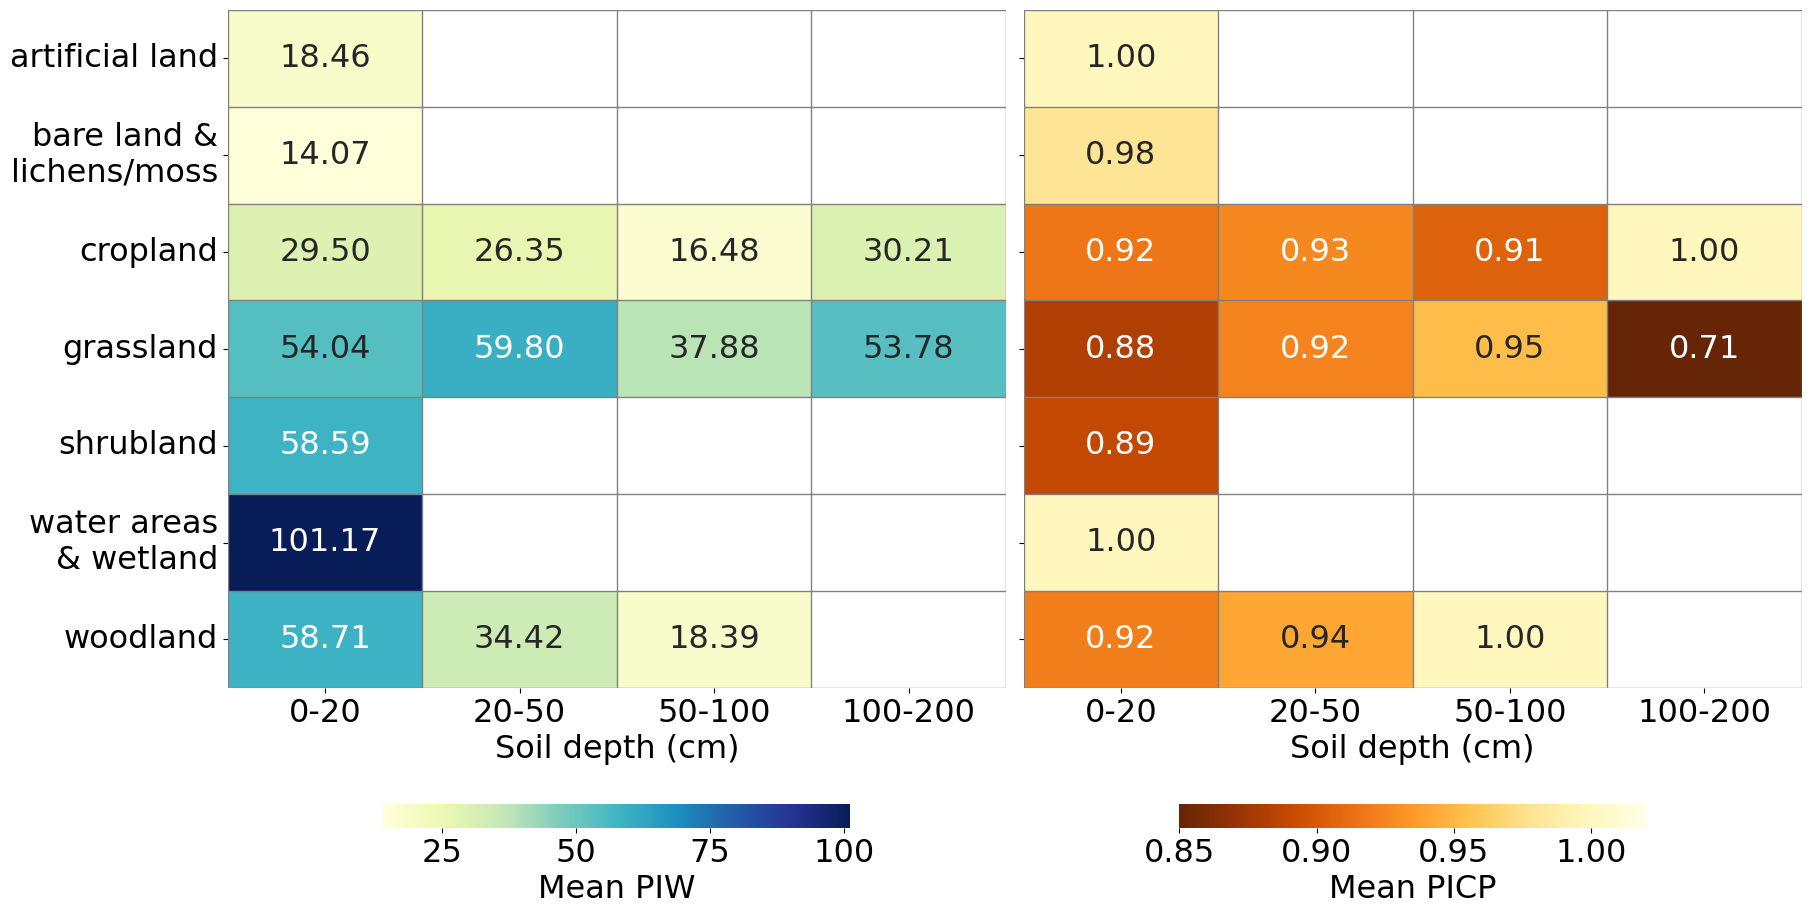

In [16]:
# Switch x and y by pivoting with lc_survey as index and hzn_dep_bin as columns
piw_pivot = grouped.pivot(index='lc_survey', columns='hzn_dep_bin', values='piw')
picp_pivot = grouped.pivot(index='lc_survey', columns='hzn_dep_bin', values='picp')

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(18, 9), constrained_layout=True, sharey=True)  # Share x-axis

# Heatmap for PIW
sns.heatmap(
    piw_pivot,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    annot_kws={"fontsize": 23},
    cbar_kws={'label': 'Mean PIW', 'orientation': 'horizontal', 'shrink': 0.6},
    ax=axes[0],
    # vmax = 60
)
axes[0].set_xlabel("Soil depth (cm)", fontsize=23)
axes[0].set_ylabel("", fontsize=23)
axes[0].set_xticklabels(piw_pivot.columns, fontsize=23)  # Soil depth bins as x-axis labels
axes[0].tick_params(axis='y', rotation = 0, labelsize=23)
axes[0].collections[0].colorbar.ax.tick_params(labelsize=23)  # Colorbar tick size
axes[0].collections[0].colorbar.set_label('Mean PIW', size=23)
        
# add grid line
for i in range(piw_pivot.shape[0]+1):  # Horizontal grid lines
    axes[0].axhline(i, color='grey', linewidth=1)
for j in range(piw_pivot.shape[1]+1):  # Vertical grid lines
    axes[0].axvline(j, color='grey', linewidth=1)
    
# Heatmap for PICP
sns.heatmap(
    picp_pivot,
    annot=True,
    fmt=".2f",
    cmap="YlOrBr_r",
    cbar_kws={'label': 'Mean PICP', 'orientation': 'horizontal', 'shrink': 0.6},
    ax=axes[1],
    annot_kws={"fontsize": 23},
    xticklabels=piw_pivot.columns,
    vmin=0.85, 
    vmax=1.02
)
axes[1].set_xlabel("Soil depth (cm)", fontsize=23)
axes[1].set_ylabel("", fontsize=23)  # No duplicate y-label
axes[1].set_xticklabels(piw_pivot.columns, fontsize=23)  # Soil depth bins as x-axis labels
# axes[1].tick_params(axis='y', rotation=30, labelsize=23)
axes[1].collections[0].colorbar.ax.tick_params(labelsize=23)
axes[1].collections[0].colorbar.set_label('Mean PICP', size=23)

# add grid line
for i in range(picp_pivot.shape[0]+1):  # Horizontal grid lines
    axes[1].axhline(i, color='grey', linewidth=1)
for j in range(picp_pivot.shape[1]+1):  # Vertical grid lines
    axes[1].axvline(j, color='grey', linewidth=1)
    
fig.subplots_adjust(wspace=0.5)
plt.savefig(f'{folder_path}/figure/figure_metrics.pi_lc.depth.pdf', bbox_inches='tight')
plt.show()


<Axes: >

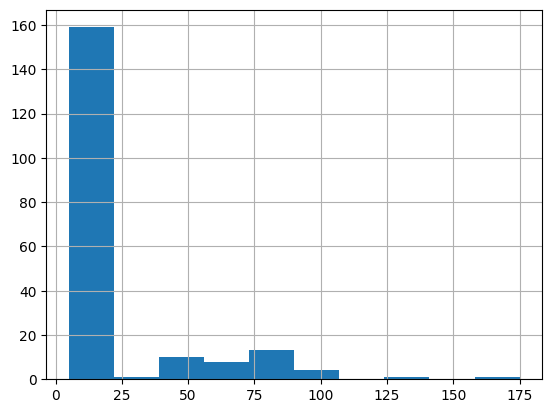

In [11]:
m = test.loc[test['picp'] == 0]
m['hzn_dep'].hist()

# Examine PIW and PICP against SOCD

In [12]:
bins = np.linspace(0,150,16)

# Sorting the true values
y_true = test[prop].values
sorted_indices = np.argsort(y_true)
pred_p975 = y_q[23,:]
pred_p025 = y_q[1,:]

# Reordering the arrays based on the sorted indices
sorted_true_values = y_true[sorted_indices]
sorted_pred_values = y_pred[sorted_indices]
sorted_pred_p025 = pred_p025[sorted_indices]
sorted_pred_p975 = pred_p975[sorted_indices]

# Digitize the y_true values to find which bin each value belongs to
digitized = np.digitize(y_true, bins)

# Calculate mean and variance of PIW in each bin, and count data points
mean_piw = [np.mean(piw[digitized == i]) for i in range(1, len(bins))]
var_piw = [np.var(piw[digitized == i]) for i in range(1, len(bins))]
counts = [np.sum(digitized == i) for i in range(1, len(bins))]

# Calculate the standard deviation (sqrt of variance) for the error bars
std_piw = np.sqrt(var_piw)


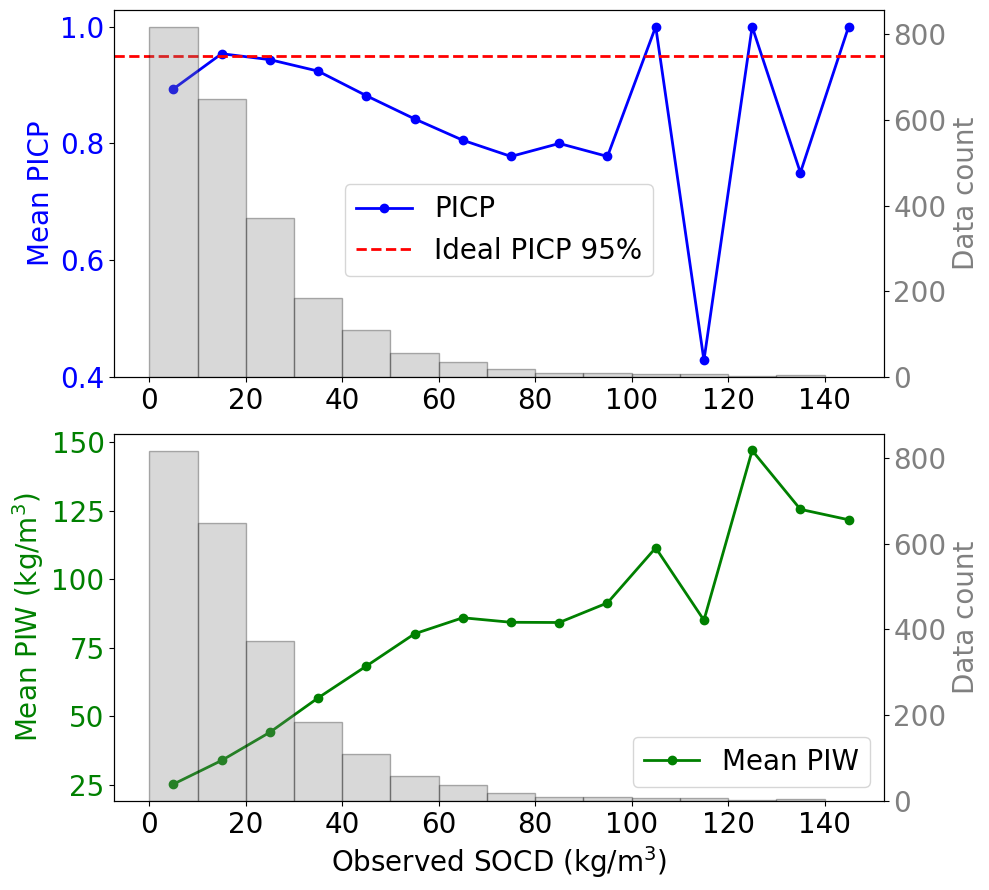

In [28]:
bin_size = 10

# Define bin edges with the adjustable bin size
bin_edges = np.arange(start=np.floor(sorted_true_values.min() / bin_size) * bin_size, 
                      stop=np.ceil(sorted_true_values.max() / bin_size) * bin_size + bin_size, 
                      step=bin_size)

# Digitize the true values to assign them to bins
bins = np.digitize(sorted_true_values, bin_edges)

# Initialize lists to store bin centers, PICP values, and PIW values
bin_centers = []
picp_values = []
piw_values = []

# Calculate the PICP and PIW for each bin
for i in range(1, len(bin_edges)):
    # Select indices where the true values fall into the current bin
    bin_indices = np.where(bins == i)[0]
    
    if len(bin_indices) > 0:
        # Calculate the PICP for the current bin
        in_interval = (sorted_pred_p025[bin_indices] <= sorted_true_values[bin_indices]) & (sorted_true_values[bin_indices] <= sorted_pred_p975[bin_indices])
        picp = np.mean(in_interval)
        
        # Calculate the PIW for the current bin
        piw = np.mean(sorted_pred_p975[bin_indices] - sorted_pred_p025[bin_indices])
        
        # Store the bin center, PICP value, and PIW value
        bin_center = (bin_edges[i] + bin_edges[i-1]) / 2
        bin_centers.append(bin_center)
        picp_values.append(picp)
        piw_values.append(piw)

# Convert lists to arrays for plotting
bin_centers = np.array(bin_centers)
picp_values = np.array(picp_values)
piw_values = np.array(piw_values)

# Create the figure with side-by-side subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9))

# Plotting the PICP and histogram in the first subplot
p1 = ax1.plot(bin_centers[0:15], picp_values[0:15], color='blue', linestyle='-', linewidth=2, marker='o', label='PICP') 
ax1.set_ylabel('Mean PICP', fontsize=20, color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.axhline(y=0.95, color='red', linestyle='--', linewidth=2)
# ax1.set_xlim([0,160])
# Adding a manual entry for the ideal PICP line
p2 = ax1.plot([], [], color='red', linestyle='--', linewidth=2, label='Ideal PICP 95%')
lines_labels = [p1[0], p2[0]]
labels = [l.get_label() for l in lines_labels]
ax1.legend(lines_labels, labels,loc='center', bbox_to_anchor=(0.5, 0.4), fontsize=20)


# Plotting the histogram on the secondary y-axis
ax3 = ax1.twinx()
ax3.hist(sorted_true_values, bins=bin_edges[0:15], color='gray', alpha=0.3, label='Histogram', edgecolor='black')
ax3.set_ylabel('Data count', fontsize=20, color='gray')
ax3.tick_params(axis='y', labelcolor='gray', labelsize=20)

# Plotting the PIW and histogram in the second subplot
p4 = ax2.plot(bin_centers[0:15], piw_values[0:15], color='green', linestyle='-', linewidth=2, marker='o', label='Mean PIW')
ax2.set_xlabel('Observed SOCD (kg/m$^3$)', fontsize=20)
ax2.set_ylabel('Mean PIW (kg/m$^3$)', fontsize=20, color='green')
ax2.tick_params(axis='y', labelcolor='green', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)

# Plotting the histogram on the secondary y-axis
ax4 = ax2.twinx()
ax4.hist(sorted_true_values, bins=bin_edges[0:15], range = (0,150),color='gray', alpha=0.3, label='Histogram', edgecolor='black')
ax4.set_ylabel('Data count', fontsize=20, color='gray')
ax4.tick_params(axis='y', labelcolor='gray', labelsize=20)

# Combine legends for the second plot
lines_labels = [p4[0]]  # Access the first element of p4
labels = [l.get_label() for l in lines_labels]
ax2.legend(lines_labels, labels, loc='lower right', fontsize=20)

# Optionally, add a title for the entire figure
# fig.suptitle('PICP and PIW with Corresponding Histogram of True SOCD Values', fontsize=24)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f'{folder_path}/figure/figure_uncertainty_picp.piw.hist.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Display the plots
plt.show()



In [ ]:
# # compute pdp 

# def custom_predict_piw(model, X):
#     tree_predictions = model.predict(X)
#     tree_predictions = np.expm1(tree_predictions)
#     quantiles = [0.025, 0.975]
#     y_q = np.percentile(tree_predictions, [q * 100 for q in quantiles], axis=0)
#     piw = y_q[1,:] - y_q[0,:]
#     return piw

# def compute_pdp(model, X, feature_index, predict_function, grid_resolution=100):
#     """
#     Compute partial dependence for a specific feature.

#     Parameters:
#     - model: The fitted model.
#     - X: The dataset (numpy array or pandas DataFrame).
#     - feature_index: The index of the feature for which to compute PDP.
#     - predict_function: Function to compute the target values.
#     - grid_resolution: Number of points in the grid.

#     Returns:
#     - values: The feature values at which PDP was computed.
#     - pdp: The corresponding partial dependence values.
#     """
#     X = X.copy()
#     feature_values = np.linspace(X.iloc[:, feature_index].min(), 
#                                  X.iloc[:, feature_index].max(), 
#                                  grid_resolution)
    
#     pdp = np.zeros(grid_resolution)
    
#     for i, val in enumerate(feature_values):
#         X.iloc[:, feature_index] = val
#         pdp[i] = predict_function(model, X).mean()

#     return feature_values, pdp

# with open('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/piw_pdp.results.pkl', 'rb') as file:
#     piw_pdp = pickle.load(file)
    
# piw_df = pd.DataFrame(columns = ['Feature', 'name', 'pdp_range', 'pdp_mean'])
    
    
# # sig = ['hzn_dep',
# #  'lithology.78.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
# #  'dtm.bareearth_ensemble_p10_30m_s_20000101_20221231_eu_epsg.3035_v20240424',
# #  'dtm.bareearth_ensemble_p10_960m_s_20000101_20221231_eu_epsg.3035_v20240424.tif',
# #  'dtm.bareearth_ensemble_p10_480m_s_20000101_20221231_eu_epsg.3035_v20240424.tif',
# #  'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
# #  'vpd.range_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531.tif',
# #  'red_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
# #  'wilderness_li2022.human.footprint_p_1km_s_{year}0101_{year}1231_eu_epsg.3035_v20240531.tif',
# #  'wv_mcd19a2v061.seasconv_m_1km_s_{year}0501_{year}0531_eu_epsg.3035_v20230619.tif']

# for i, xx in enumerate(sig):
#     if len(xx.split('_'))>2:
#         nx = xx.split('_')[0]+'_'+xx.split('_')[2]+'_'+xx.split('_')[5]+'_'+xx.split('_')[6]
#     else:
#         nx = xx
        
#     # feature_values, pdp = compute_pdp(model, test[covs], i, custom_predict_piw, grid_resolution=100)
#     pdp_piw_results[xx] = {
#         "feature_values": feature_values,
#         "pdp_values": pdp
#     }
#     feature_values = piw_pdp[xx]['feature_values']
#     pdp = piw_pdp[xx]['pdp_values']
    
#     pdp_range = np.max(pdp) - np.min(pdp)
#     pdp_mean = np.mean(pdp)
#     piw_df.loc[len(piw_df)] = [xx, nx, pdp_range, pdp_mean] 
   

# piw_df = piw_df.sort_values(by=['pdp_range'], ascending=False)#['Feature'].tolist()

# for xx in piw_df['Feature'].iloc[0:10]:
#     if len(xx.split('_'))>2:
#         nx = xx.split('_')[0]+'_'+xx.split('_')[2]+'_'+xx.split('_')[5]+'_'+xx.split('_')[6]
#     else:
#         nx = xx
        
#     pdp_piw_results[xx] = {
#         "feature_values": feature_values,
#         "pdp_values": pdp
#     }
#     feature_values = piw_pdp[xx]['feature_values']
#     pdp = piw_pdp[xx]['pdp_values']
        
#     # PDP and histogram
#     fig, ax1 = plt.subplots(figsize=(10, 6))
    
#     # Plot the PDP
#     ax1.plot(feature_values, pdp, color='blue', label='PDP')
#     ax1.set_title(nx, fontsize=20)
#     ax1.set_xlabel(f"Feature values", fontsize=20)
#     ax1.set_ylabel("PIW (PDP)", fontsize=20, color='blue')
#     ax1.tick_params(axis='both', labelsize=20)
#     ax1.tick_params(axis='y', labelcolor='blue')
    
#     # Create a second y-axis sharing the same x-axis
#     ax2 = ax1.twinx()
    
#     # Plot the histogram
#     ax2.hist(test[xx], bins=100, color='orange', alpha=0.5) #, edgecolor='black'
#     ax2.set_ylabel("Counts", fontsize=20, color='orange')
#     ax2.tick_params(axis='y', labelsize=20)
#     ax2.tick_params(axis='y', labelcolor='orange')
    
#     # Show the plot
#     fig.tight_layout()
#     plt.show()
    
# #     fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
# #     # Plot the PDP on the left
# #     ax[0].plot(feature_values, pdp)
# #     ax[0].set_title(f"PDP - {nx}", fontsize=20)
# #     ax[0].set_ylabel("PIW", fontsize=20)
# #     ax[0].set_xlabel(f"Feature: {nx}", fontsize=20)
# #     ax[0].tick_params(axis='both', labelsize=20)
    
# #     # Plot the histogram of the feature values on the right
# #     ax[1].hist(test[xx], bins=20, color='orange') #, edgecolor='black'
# #     ax[1].set_title(f"Histogram - {nx}", fontsize=20)
# #     ax[1].set_ylabel("Frequency", fontsize=20)
# #     ax[1].set_xlabel(f"Feature values", fontsize=20)
# #     ax[1].tick_params(axis='both', labelsize=20)
    
# #     plt.tight_layout()
# #     plt.show()
